In [1]:
import os
from pathlib import Path

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch import nn

from tqdm.auto import tqdm,trange

from transformers import AdamW


BATCH_SIZE = 64

In [2]:
!rm -rf PoS-Tagging
!git clone https://github.com/Janluke0/PoS-Tagging/
os.chdir('PoS-Tagging')
out_dir = Path('/kaggle/working/')
out_dir.mkdir(exist_ok=True)

Cloning into 'PoS-Tagging'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 77 (delta 27), reused 71 (delta 21), pack-reused 0
Unpacking objects: 100% (77/77), 658.28 KiB | 837.00 KiB/s, done.


In [3]:
from model.transformers.italian import ItELECTRACasedPos,ItELECTRAXXLCasedPos
from dataset import TWITADS

## Common

this part should be adde to the repo, it's time to go lighting

In [4]:

def train_model(model, dl_train, dl_test, cuda=False, lr=0.001, epochs=10, show_plots=False, save_dir=None):
    loss_function = nn.NLLLoss()
    optimizer = AdamW(model.parameters(), lr=lr,weight_decay=0.01)
    
    if cuda:
        model = model.cuda()
    if save_dir is not None:
        save_dir.mkdir(exist_ok=True)
    
    losses = []
    accuracies = []
    best_acc = 0
    best_loss = float('inf')
    pbar = trange(epochs)
    for epoch in pbar:
        model.train()
        for sample in tqdm(iter(dl_train), desc=f"Training {epoch}° epoch", leave=False):
            x,m,y = sample['input_ids'],sample['attention_mask'], sample['labels']
            if cuda:
                x, m, y = x.cuda(), m.cuda(), y.cuda()
            optimizer.zero_grad()
            
            tag_scores =  model(input_ids=x,attention_mask=m)
            loss = loss_function(tag_scores.transpose(1, 2),y)

            loss.backward()
            optimizer.step()
            
        acc = []
        los = []
        ## evaluation
        model.eval()
        with torch.no_grad():
            for sample in tqdm(iter(dl_test), desc=f"Eval {epoch}° epoch", leave=False):
                x,m,y = sample['input_ids'],sample['attention_mask'], sample['labels']
                if cuda:
                    x, m, y = x.cuda(), m.cuda(), y.cuda()
                    
                tag_scores =  model(input_ids=x,attention_mask=m)
                if hasattr(tag_scores,'logits'):
                    tag_scores = tag_scores.logits
                    
                loss = loss_function(tag_scores.transpose(1, 2),y)
                los.append(loss.cpu().item())
                
                acc.append(((tag_scores.argmax(2))==y)[m==1].float())
            
        acc = torch.cat(acc).mean().item()
        los = np.array(los).mean()

        losses.append(los)
        accuracies.append(acc)
        #show epoch results
        pbar.set_description(f"Loss:{los}\tAccurancy:{acc}")
        if show_plots:
            plt.subplot(121)
            plt.title("Test loss")
            plt.plot(losses)

            plt.subplot(122)
            plt.title("Test accuracy")
            plt.plot(accuracies)
        if save_dir is not None and acc >= best_acc:
            torch.save(model.state_dict(),save_dir/f"model_best_acc.pth")
        if save_dir is not None and loss <= best_loss:
            torch.save(model.state_dict(),save_dir/f"model_best_loss.pth")
        
        best_acc = max(acc,best_acc)
        best_loss = max(los,best_loss)
    
    return losses,accuracies

def show_pred(model, ds, i):
    REVTAG = {v:k for k,v in ds._TAGS.items()}
    model.cpu()
    sample = ds.collate([ds[i]])
    x,m,y = sample['input_ids'],sample['attention_mask'], sample['labels']
    with torch.no_grad():
        pred = model(input_ids=x,attention_mask=m)
    tkns = ds.tokenizer.convert_ids_to_tokens(x[0,1:-1])
    return list(zip(tkns,[REVTAG[v.item()] for v in pred[0].argmax(1)[1:-1]],[REVTAG[v.item()] for v in y[0][1:-1]]))

In [5]:
def collate_fn(batch):
    input_ids, token_type_ids, attention_mask, labels = [[] for _ in range(4)] 
    for sample in batch:
        input_ids.append(sample['input_ids'])
        token_type_ids.append(sample['token_type_ids'])
        attention_mask.append(sample['attention_mask']) 
        labels.append(sample['labels'])
    return {
        'input_ids':pad_sequence(input_ids,batch_first=True),
        'token_type_ids': pad_sequence(token_type_ids,batch_first=True),
        'labels':pad_sequence(labels, padding_value=-100,batch_first=True),
        'attention_mask':pad_sequence(attention_mask,batch_first=True),
    }


In [6]:
def tokenize_and_align_labels(tokenizer, tokens, tags):
    tokens = list(tokens)
    tokenized_inputs = tokenizer(tokens, truncation=True, is_split_into_words=True)
    
    word_ids = tokenized_inputs.word_ids(batch_index=0)  # Map tokens to their respective word.
    previous_word_idx = None
    label_ids = []
    for word_idx in word_ids:                            # Set the special tokens to -100
        if word_idx is None:
            label_ids.append(-100)
        elif word_idx != previous_word_idx:              # Only label the first token of a given word.
            label_ids.append(tags[word_idx])

    tokenized_inputs["labels"] = label_ids
    
    return {k:torch.tensor(v) for k,v in tokenized_inputs.items()}

## mc4 model

In [7]:
mc4_model = ItELECTRACasedPos(23)

Downloading:   0%|          | 0.00/686 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/electra-base-italian-mc4-cased-discriminator were not used when initializing ElectraForTokenClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at dbmdz/electra-base-italian-mc4-cased-discriminator and are newly initi

In [8]:
tokenizer = ItELECTRACasedPos.tokenizer()
ds_train = TWITADS('resampled_train',
                 lambda w:[w], 
                 transform=lambda a,b: tokenize_and_align_labels(tokenizer,a,b)
)
ds_val = TWITADS('resampled_validation',
                 lambda w:[w], 
                 transform=lambda a,b: tokenize_and_align_labels(tokenizer,a,b)
)

Downloading:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/230k [00:00<?, ?B/s]

In [9]:
dl_train = DataLoader(ds_train, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn)
dl_val  = DataLoader(ds_val, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn)

  0%|          | 0/40 [00:00<?, ?it/s]

Training 0° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 0° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 1° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 1° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 2° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 2° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 3° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 3° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 4° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 4° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 5° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 5° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 6° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 6° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 7° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 7° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 8° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 8° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 9° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 9° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 10° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 10° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 11° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 11° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 12° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 12° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 13° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 13° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 14° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 14° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 15° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 15° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 16° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 16° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 17° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 17° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 18° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 18° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 19° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 19° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 20° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 20° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 21° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 21° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 22° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 22° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 23° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 23° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 24° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 24° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 25° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 25° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 26° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 26° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 27° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 27° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 28° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 28° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 29° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 29° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 30° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 30° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 31° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 31° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 32° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 32° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 33° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 33° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 34° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 34° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 35° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 35° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 36° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 36° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 37° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 37° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 38° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 38° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 39° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 39° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

([2.03640501499176,
  1.7408401489257812,
  1.6898200631141662,
  1.664677894115448,
  1.6550066471099854,
  1.6488304495811463,
  1.641623079776764,
  1.6431013941764832,
  1.643381667137146,
  1.6387795448303222,
  1.63668555021286,
  1.6415698170661925,
  1.6437358736991883,
  1.6430535554885863,
  1.6445921182632446,
  1.6428797125816346,
  1.6463431239128112,
  1.6504170298576355,
  1.6505876898765564,
  1.650406789779663,
  1.6526689291000367,
  1.6517019391059875,
  1.6518890380859375,
  1.6510832071304322,
  1.655223000049591,
  1.6560324430465698,
  1.6557697892189025,
  1.6530117630958556,
  1.6559265017509461,
  1.6547646045684814,
  1.657817280292511,
  1.653559148311615,
  1.653713059425354,
  1.6519393086433412,
  1.6572758078575134,
  1.6560091733932496,
  1.6590068221092225,
  1.6578777313232422,
  1.6527382850646972,
  1.6618884563446046],
 [0.8433812260627747,
  0.8830790519714355,
  0.8913741111755371,
  0.8942872881889343,
  0.8950278759002686,
  0.900113582611084,


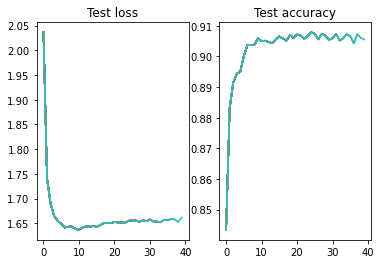

In [10]:
torch.manual_seed(42)
train_model(mc4_model,dl_train,dl_val,cuda=torch.cuda.is_available(), lr=2e-5, epochs=40, show_plots=True, save_dir=out_dir/"mc4_model")

## Uncased model

In [11]:
xxl_model =ItELECTRAXXLCasedPos(23)

Downloading:   0%|          | 0.00/467 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/electra-base-italian-xxl-cased-discriminator were not used when initializing ElectraForTokenClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at dbmdz/electra-base-italian-xxl-cased-discriminator and are newly initi

In [12]:
tokenizer = ItELECTRAXXLCasedPos.tokenizer()
ds_train = TWITADS('resampled_train',
                 lambda w:[w], 
                 transform=lambda a,b: tokenize_and_align_labels(tokenizer,a,b)
)
ds_val = TWITADS('resampled_validation',
                 lambda w:[w], 
                 transform=lambda a,b: tokenize_and_align_labels(tokenizer,a,b)
)

Downloading:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/230k [00:00<?, ?B/s]

In [13]:
dl_train = DataLoader(ds_train, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn)
dl_val  = DataLoader(ds_val, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn)

  0%|          | 0/40 [00:00<?, ?it/s]

Training 0° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 0° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 1° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 1° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 2° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 2° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 3° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 3° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 4° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 4° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 5° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 5° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 6° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 6° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 7° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 7° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 8° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 8° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 9° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 9° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 10° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 10° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 11° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 11° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 12° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 12° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 13° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 13° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 14° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 14° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 15° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 15° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 16° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 16° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 17° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 17° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 18° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 18° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 19° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 19° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 20° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 20° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 21° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 21° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 22° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 22° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 23° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 23° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 24° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 24° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 25° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 25° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 26° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 26° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 27° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 27° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 28° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 28° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 29° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 29° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 30° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 30° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 31° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 31° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 32° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 32° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 33° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 33° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 34° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 34° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 35° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 35° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 36° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 36° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 37° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 37° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 38° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 38° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 39° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 39° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

([1.8941421389579773,
  1.697704815864563,
  1.6630659103393555,
  1.6501924037933349,
  1.644134283065796,
  1.6426794886589051,
  1.6391411423683167,
  1.638886296749115,
  1.635600733757019,
  1.6371947884559632,
  1.632011342048645,
  1.638020431995392,
  1.64007648229599,
  1.6401451706886292,
  1.6420645475387574,
  1.6433884739875793,
  1.6441566348075867,
  1.6422365188598633,
  1.6461059331893921,
  1.6471192479133605,
  1.645556092262268,
  1.648843777179718,
  1.6501785159111022,
  1.6515424489974975,
  1.6503690958023072,
  1.6521593928337097,
  1.6550783038139343,
  1.6489670991897583,
  1.6582000613212586,
  1.6511274218559264,
  1.655085527896881,
  1.6554555654525758,
  1.6525050401687622,
  1.6511088728904724,
  1.655785608291626,
  1.6527089476585388,
  1.6493215084075927,
  1.6608516097068786,
  1.6534362316131592,
  1.6585968017578125],
 [0.8638226389884949,
  0.8858440518379211,
  0.8902384638786316,
  0.8928554058074951,
  0.8951266407966614,
  0.8976941704750061,

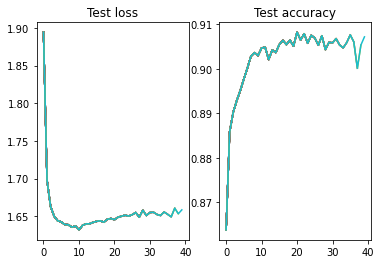

In [14]:
torch.manual_seed(42)
train_model(xxl_model,dl_train,dl_val,cuda=torch.cuda.is_available(), lr=2e-5, epochs=40, show_plots=True,save_dir=out_dir/"xxl_model")

In [15]:
#remove repo from saved output
!rm -rf /kagle/working/PoS-Tagging

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
